# 4.0_SynAnalyzer_PlotSynAnalysis_Runx1NIHL_2025.ipynb
Created by: JFranco | 28 JAN 2025 | Env: QISHA | Last run: 28 JAN 2025

This updated version of the PlotSynAnalysis notebook for the Runx1 data varies from the original version in the way that it pools imaging and sample metadata. Rather than accessing the Prep folders to get data, it uses the specific imaging metadata sheet used by Taylor that has all images from all preps. It also chooses what to plot based purely on the available XYZ analysis files rather than what is in the imaging or Batch Master sheets. 

In [6]:
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import math
from scipy import stats
from scipy.stats import ks_2samp

In [7]:
#                   *** GET TIME OF ANALYSIS START ***
# could turn this into a module?
toa = str(datetime.datetime.today()).split()                                   #Time of analysis
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]

In [8]:
#                *** WHAT TO ANALYZE // WHERE TO GET/STORE **
# Key identifiers
batchID = 'Runx1NIHL_SynAnalyzer'
# Metadata fields to grab from the imaging metadata sheet & transfer to the image summary sheet
mdIFields = ['SlideID','Freq','NoHCRecon']
# Metadata fields to grab from the sample sheet & transfer to the image summary sheet
mdSFields = ['AnimalID','Sex','DOB','Genotype','Treatment','NoiseExposed']

# Surfaces to include in the analysis
surfs = ['PreSyn','PostSyn']
# Define condition (used for plotting) - Variables declared above and pasted here for reference
#   The base level code is setup to test up to two different condition sets
#   If only condition set is used, the variables may appear redundant
condToTest = ['Genotype','NoiseExposed']
condOneVals = ['B5Cre+/-;Runx1Fl+/+','B5Cre-/-;Runx1Fl+/+',]
condTwoVals = ['Exposed','Sham',]
conditions = ['Cre+;Exposed','Cre+;Sham', 'Cre-;Exposed', 'Cre-;Sham']
# Parameters for plotting
pltOrder = conditions
colors = {pltOrder[0]:'rebeccapurple' , pltOrder[1]:'thistle', pltOrder[2]:'darkcyan', pltOrder[3]:'paleturquoise'}
ecdfColors = ['rebeccapurple','thistle','darkcyan','paleturquoise']

# Directories 
#   existing ones 
dirMain = '/Users/joyfranco/Partners HealthCare Dropbox/Joy Franco/JF_Shared/Data/FromCollaborators/Copeland2024/'
dirBA = dirMain+batchID+'/'
dirMD = dirBA+'Metadata/'
dirSA = dirBA+'SAR.Analysis/'

#   ones that need to be made    
dirRes = dirBA+'SAR.Results/'
dirTR = dirRes+timestamp+'/'

# Files to access
fnMDSamp = batchID+'.Metadata.Samples.csv'
fnMDIms = batchID+'.Metadata.Imaging.xlsx'
fnBM = 'SynAnalyzerBatchMaster.csv'

# Files to make
fnSS = batchID+'.ImageSummarySheet.csv'

In [9]:
#  *** INITIALIZE RUN SPECIFIC DIRECTORY ETC FOR STORING RESULTS **
# Create directory for storing spreadsheetS and summary plotS for this run
if not os.path.exists(dirRes): os.mkdir(dirRes)
if not os.path.exists(dirTR): os.mkdir(dirTR)

In [10]:
#  *** LOAD METADATA AND BATCH MASTER FILES ***
dfSamps = pd.read_csv(dirMD+fnMDSamp)
dfSamps.reset_index(inplace=True)
dfSamps.drop('index', axis=1, inplace=True)
dfIms = pd.read_excel(dirMD+fnMDIms, sheet_name="63xImages")
dfIms.reset_index(inplace=True)
dfIms.drop('index', axis=1, inplace=True)
dfBM = pd.read_csv(dirSA+fnBM)
dfBM.reset_index(inplace=True)

In [30]:
#  *** MAKE MAIN DF BASED ON AVAILABLE FILES ***
# Initialize a data frame for storying all XYZ data
dfXYZAll = pd.DataFrame()
# Get list of all files and initialize df for storing info
os.chdir(dirSA)
files = glob.glob('*Syn.csv')
dfFiles = pd.DataFrame({'Filename':files})
# Iterate through the files and build info
for file in dfFiles['Filename']:
    # Get the index of the file in the main df
    inF = dfFiles.index[dfFiles['Filename']==file].tolist()[0]
    # Get the identifying info from filename
    imName = file[0:22]
    surfType = file[27:len(file)-4]
    samp = file[0:10]

    # Get information about sample from the dfSamps
    inSamp = dfSamps.index[dfSamps['SampleID']==samp].tolist()[0]
    anID = dfSamps.loc[inSamp]['AnimalID']
    geno = dfSamps.loc[inSamp]['Genotype']
    neStatus = dfSamps.loc[inSamp]['NoiseExposed']

    # Define condition (used for plotting) - Variables declared above and pasted here for reference
    # condToTest = ['Genotype','NoiseExposed']
    # condOneVals = ['B5Cre+/-;Runx1Fl+/+','B5Cre-/-;Runx1Fl+/+',]
    # condTwoVals = ['Exposed','Sham',]
    # conditions = ['Cre+ Exposed','Cre+ Sham', 'Cre- Exposed', 'Cre- Sham']
    if ((geno == condOneVals[0]) & (neStatus == condTwoVals[0])):
        # Condition = Cre+ Exposed
        cond = conditions[0]
    elif ((geno == condOneVals[0]) & (neStatus == condTwoVals[1])):
        # Condition = Cre+ Sham 
        cond = conditions[1]
    elif ((geno == condOneVals[1]) & (neStatus == condTwoVals[0])):
        # Condition = Cre- Exposed 
        cond = conditions[2]
    elif ((geno == condOneVals[1]) & (neStatus == condTwoVals[1])):
        # Condition = Cre- Sham 
        cond = conditions[3]

    # Get information about the image from the imaging metadata sheet
    inIm = dfIms.index[dfIms['ImageName']==imName].tolist()[0]
    freq = dfIms.loc[inIm]['Freq']
    noHCs = dfIms.loc[inIm]['# IHCs']

    # Get information about this file from Batch Master
    inBM = dfBM.index[dfBM['ImageName']==(imName+'.czi')].tolist()[0]
    bmPill = int(dfBM.loc[inBM]['PreSyn_nPillar'])
    bmMod = int(dfBM.loc[inBM]['PreSyn_nModiolar'])
    bmSyn = bmPill+bmMod
    if (bmSyn != 0):
        bmModProp = bmMod/(bmPill+bmMod)
    else:
        bmModProp = 0

    # ADD XYZ data to df for all XYZs will appropriate metadata
    #  Start by loading the file
    dfXYZ = pd.read_csv(dirSA+file)
    #  Add important md to each row
    dfXYZ['ImageName']=imName
    dfXYZ['Genotype']=geno
    dfXYZ['NoiseExposed']=neStatus
    dfXYZ['Frequency']=freq
    dfXYZ['Surf']=surfType
    dfXYZ['Condition']=cond
    # Count the number of surfaces and categories
    nAll = len(dfXYZ)
    nSyns = len(dfXYZ[dfXYZ['SynapseStatus']==('Synapse' or 'Doublet')])
    nOrph = len(dfXYZ[dfXYZ['SynapseStatus']==('Orphan')])
    nPill = len(dfXYZ[(dfXYZ['Pillar-ModiolarStatus']==('Pillar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
    nMod = len(dfXYZ[(dfXYZ['Pillar-ModiolarStatus']==('Modiolar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
    uVol = dfXYZ['Volume_um3'].mean()
    uCh1 = dfXYZ['uIntCh_1'].mean()
    uCh2 = dfXYZ['uIntCh_2'].mean()
    uCh3 = dfXYZ['uIntCh_3'].mean()
    uCh4 = dfXYZ['uIntCh_4'].mean()
    maxCh1 = dfXYZ['uIntCh_1'].max()
    
    # Calculate the mean normalized vals for each surface
    dfXYZ['uNormVol'] = dfXYZ['Volume_um3']/uVol
    dfXYZ['uNormIntCh1'] = dfXYZ['uIntCh_1']/uCh1
    dfXYZ['uNormIntCh2'] = dfXYZ['uIntCh_2']/uCh2
    dfXYZ['uNormIntCh3'] = dfXYZ['uIntCh_3']/uCh3
    dfXYZ['uNormIntCh4'] = dfXYZ['uIntCh_4']/uCh4
    dfXYZ['maxNormIntCh1'] = dfXYZ['uIntCh_1']/maxCh1
    
    # Add it to the main df
    dfXYZAll = pd.concat([dfXYZAll,dfXYZ])

    # Set info
    dfFiles.at[inF,'ImageName'] = imName
    dfFiles.at[inF,'Freq'] = freq
    dfFiles.at[inF,'SurfaceType'] = surfType
    dfFiles.at[inF,'AnimalID'] = anID
    dfFiles.at[inF,'Genotype'] = geno
    dfFiles.at[inF,'NoiseExposed'] = neStatus
    dfFiles.at[inF,'Condition'] = cond
    dfFiles.at[inF,'NoHCRecon'] = neStatus
    dfFiles.at[inF,'bmSyn'] = bmSyn
    dfFiles.at[inF,'bmSynPerHC'] = bmSyn/noHCs
    dfFiles.at[inF,'bmPill'] = bmPill
    dfFiles.at[inF,'bmMod'] = bmMod
    dfFiles.at[inF,'bmModProp'] = bmModProp
    dfFiles.at[inF,'xyzSurfs'] = nAll
    dfFiles.at[inF,'xyzSyns'] = nSyns
    dfFiles.at[inF,'xyzSynPerHC'] = nSyns/noHCs
    dfFiles.at[inF,'xyzPill'] = nPill
    dfFiles.at[inF,'xyzMod'] = nMod
    if(nSyns !=0):
        dfFiles.at[inF,'xyzModProp'] = nMod/(nPill+nMod)
    else:
        dfFiles.at[inF,'xyzModProp'] = 0
    

In [31]:
# Save the updated sheets
dfXYZAll.to_csv(dirTR+batchID+'.XYZSummary.csv') 
dfFiles.to_csv(dirTR+batchID+'.FileSummary.csv') 

In [32]:
grpStats = dfFiles[(dfFiles['Freq']==32)&(dfFiles['SurfaceType']=='PostSyn')].groupby('Condition').describe()
grpStats.to_csv(dirTR+'GroupByStats.csv', index=True)

### GENERATE PLOTS

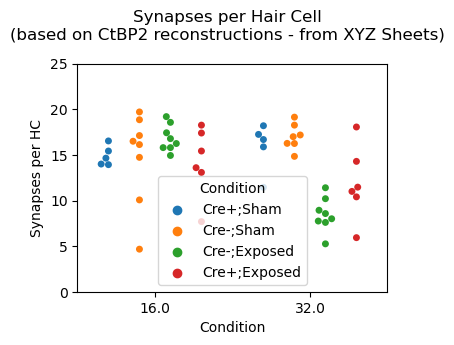

In [14]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'XYZ_SynPerHC'
plottype = 'BoxSwarm'
title = 'Synapses per Hair Cell\n(based on CtBP2 reconstructions - from XYZ Sheets)'
hue = 'Condition'
x = 'Freq'
y = 'xyzSynPerHC'
surfType = 'PostSyn'
ymin = 0
ymax = 25
xlab = 'Condition'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)

ax1 = sns.swarmplot(data=dfFiles[(dfFiles['SurfaceType']==surfType)],x=x,y=y, hue=hue,legend = True, dodge = True)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
#ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+surfType+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

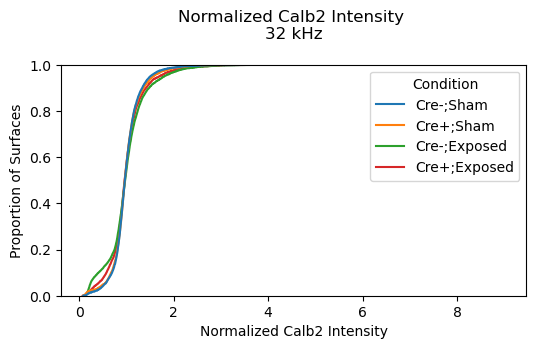

In [41]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSynCalb2Int'
plottype = 'Hist'
region = 32
title = 'Normalized Calb2 Intensity \n'+str(region)+' kHz\n'
surfType = 'PostSyn'
hue = 'Condition'
x = 'uNormIntCh1'
xlab = 'Normalized Calb2 Intensity'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(6, 3))
#ax = sns.histplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)],x=x, hue=hue, kde=True)
ax = sns.ecdfplot(data=dfXYZAll,x=x, hue=hue)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)

    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

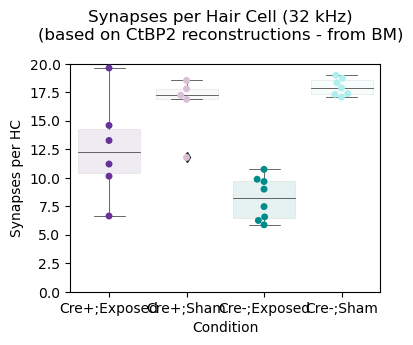

In [54]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'bmSynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'Synapses per Hair Cell ('+str(region)+' kHz)\n(based on CtBP2 reconstructions - from BM)'
hue = 'Condition'
x = 'Condition'
y = 'xyzSynPerHC'
surfType = 'PreSyn'
ymin = 0
ymax = 25
xlab = 'Condition'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfFiles[(dfFiles['Freq']==region)&(dfFiles['SurfaceType']==surfType)],
                    x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfFiles[(dfFiles['Freq']==region)&(dfFiles['SurfaceType']==surfType)],
            x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.'+surfType+'.png',  bbox_inches='tight', dpi = 300,format = 'png')